In [1]:
import os
from torchvision import datasets
import torchvision
import torch
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()


In [22]:
batch_size = 5
model_path = "E:/Smoke/"
model_name = "Increasedvalidationdata.pt"
model_path = model_path + model_name
num_workers = 0


transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_set = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train'
valid_set = 'E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Validation'

train_data = datasets.ImageFolder(train_set, transform=transform)
valid_data = datasets.ImageFolder(valid_set, transform=transform)

a = train_data.class_to_idx
print(a)
# print(a["Train"])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

{'Fire': 0, 'Neutral': 1, 'Smoke': 2}


In [11]:
train_data

Dataset ImageFolder
    Number of datapoints: 420
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [12]:
valid_data


Dataset ImageFolder
    Number of datapoints: 180
    Root location: E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
class_names = ['Fire', 'Neutral', 'Smoke']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Fire', 'Neutral', 'Smoke']


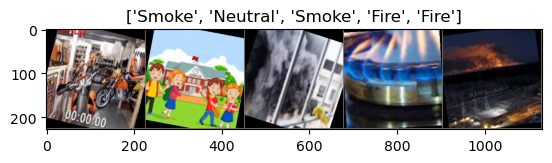

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = loaders["train"].dataset.classes
print(class_names)

# Get a batch of training data
inputs, classes = next(iter(train_loader))
# print(inputs, classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
model = models.resnet50(pretrained=True)


use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()

# model

c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,3),
                                       torch.nn.Softmax()
                                      )

for param in model.fc.parameters():
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model.cuda()
else:
    print("entered else")
model_transfer = model

# model

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

In [19]:
n_epochs = 4

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, save_path):
    
    valid_loss_min = np.Inf
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loader['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
        for batch_idx, (data, target) in enumerate(loader['valid']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(loader['train'].dataset)
        valid_loss = valid_loss/len(loader['valid'].dataset)
        train_acc = train_acc/len(loader['train'].dataset)
        valid_acc = valid_acc/len(loader['valid'].dataset)
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss  
            
    return model

In [23]:

model = train(n_epochs, loaders, model, optimizer, criterion, model_path)


c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 1 	Training Acc: 0.840476 	Training Loss: 0.001729 	Validation Acc: 0.400000 	Validation Loss: 0.006228
Validation loss decreased (inf --> 0.006228).  Saving model ...
Epoch: 2 	Training Acc: 0.828571 	Training Loss: 0.001733 	Validation Acc: 0.322222 	Validation Loss: 0.006675
Epoch: 3 	Training Acc: 0.857143 	Training Loss: 0.001703 	Validation Acc: 0.327778 	Validation Loss: 0.006575
Epoch: 4 	Training Acc: 0.854762 	Training Loss: 0.001686 	Validation Acc: 0.316667 	Validation Loss: 0.006717


Last loss:  tensor(0.0017, device='cuda:0')


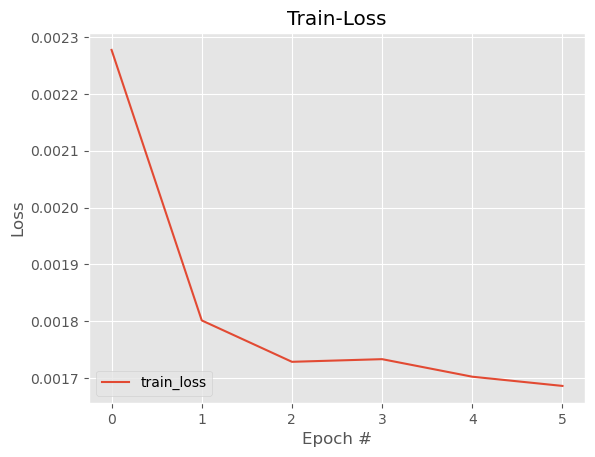

In [24]:
plt.style.use("ggplot")
plt.figure()
loss_lis = [tensor.item() for tensor in train_loss_list]

""" The training loss should decrease over time as the model learns from the data. 
However, a very low training loss doesn't necessarily mean the model 
will perform well on new, unseen data, as it may have overfit the training data"""

print("Last loss: ", train_loss_list[-1])
plt.plot(loss_lis, label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


Train accuracy mean:  tensor(0.8052)
Valid accuracy mean:  tensor(0.3315)


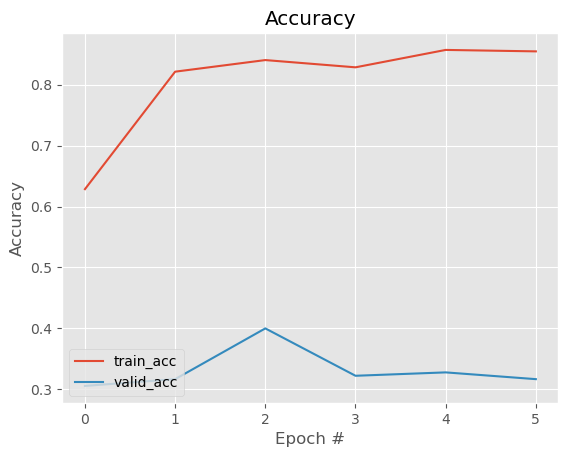

In [25]:
plt.style.use("ggplot")
plt.figure()

print()
train_acc_lis = [tensor.item() for tensor in train_accuracy_list]
valid_acc_lis = [tensor.item() for tensor in valid_accuracy_list]

mean_accuracy_train = torch.tensor(train_accuracy_list)
mean_accuracy_train = mean_accuracy_train.mean()
print("Train accuracy mean: ", mean_accuracy_train)
mean_accuracy_valid = torch.tensor(valid_accuracy_list)
mean_accuracy_valid = mean_accuracy_valid.mean()
print("Valid accuracy mean: ", mean_accuracy_valid)

plt.plot(train_acc_lis, label="train_acc")
plt.plot(valid_acc_lis, label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [213]:
torch.save(model, 'laptestingmodel_2000epochs')

In [27]:
from PIL import Image

class_names = ['Fire', 'Neutral', 'Smoke']

def predict(image, model):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.cuda()

    pred = model(image)
    idx = torch.argmax(pred)
    print(idx, "idx")
    prob = pred[0][idx].item()*100

    # print(class_names[idx], "class_names[idx]")
    
    return class_names[idx], prob

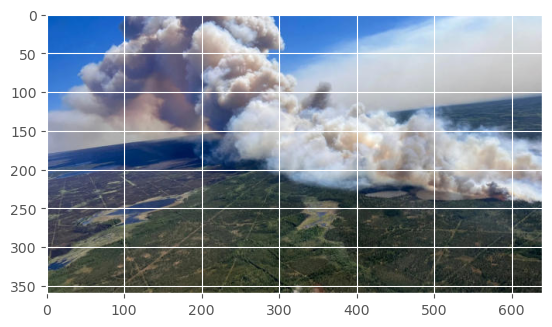

c:\Users\XYMA_HPC\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(2, device='cuda:0') idx
Smoke 99.98890161514282


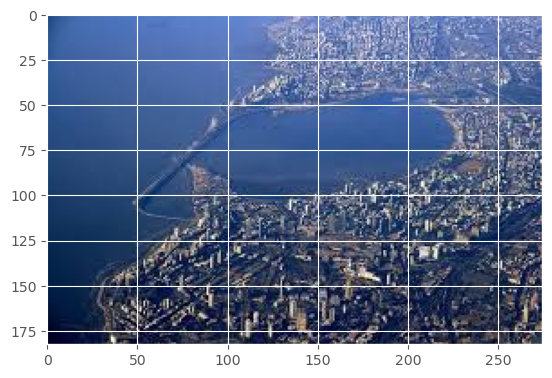

tensor(2, device='cuda:0') idx
Smoke 64.03773427009583


FileNotFoundError: [Errno 2] No such file or directory: 'E:/Smoke/Datacluster Fire and Smoke Sample (84).jpg'

In [28]:
def test(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

    prediction, prob = predict(img, model=model)
    print(prediction, prob)
    

# for idx, img_file in enumerate(os.listdir('E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train/Neutral')):
 
#     if idx > 5:
#         print(img_file, "IMG FILE")
#         img_path = os.path.join('E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Train/Neutral', img_file)
#         test(img_path)
    
test("E:/Smoke/smoke1.jpg")
test("C:/Users/XYMA_HPC/Downloads/images - 2024-01-10T145341.358.jpg")
test("E:/Smoke/Datacluster Fire and Smoke Sample (84).jpg")
test("E:/Smoke/Dataset_100/Datacluster_Fire_and_Smoke_Sample/Others/download (15).jpg")

In [216]:
import cv2

In [217]:

def show_available_cameras():
    for i in range(1):  # Checking up to index 9 (adjust this number as needed)
        print("entered for")
        cap = cv2.VideoCapture(i)
        if not cap.isOpened():
            print("Camera is not available")
        if cap.isOpened():
            print(f"Camera index {i} is available.")
            cap.release()
            return i



def live_stream_predict(model_path, webcam_index):
    # Load your pretrained model
    loaded_model = torch.load(model_path)
    loaded_model.eval()  # Set the model to evaluation mode
    
    webcam_index = webcam_index
    cap = cv2.VideoCapture(webcam_index) #VideoCapture(The webcam index refers to the identification number assigned to your webcam by the system. )
    
    while True:
        ret, frame = cap.read()  # Read a frame from the webcam
        cv2.imshow('frame', frame)  # Display the frame
        
        # Convert the OpenCV frame to PIL image format
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        prediction, prob = predict(pil_img, loaded_model)  # Use the loaded model for predictions
        
        # Show the prediction on the frame
        cv2.putText(frame, f"Prediction: {prediction} ({prob:.2f}%)", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.imshow('frame', frame)  # Display the frame with prediction
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [218]:
webcam_index = show_available_cameras()
live_stream_predict(model_path="E:/Smoke/laptestingmodel_2000epochs.pt", webcam_index=webcam_index)

entered for
Camera index 0 is available.


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'